In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from global_land_mask import globe
import scipy.stats as stats

In [2]:
# Load datasets
dataset_path = '/data/fast1/surface-load/'
ds = xr.open_dataset(dataset_path + "GRCTellus.JPL.200204_202102.GLO.RL06M.MSCNv02CRI.nc")

In [3]:
ds

<xarray.Dataset>
Dimensions:        (lon: 720, lat: 360, time: 194, bounds: 2)
Coordinates:
  * lon            (lon) float64 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * lat            (lat) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time           (time) datetime64[ns] 2002-04-17T12:00:00 ... 2021-02-15
Dimensions without coordinates: bounds
Data variables:
    lwe_thickness  (time, lat, lon) float64 ...
    uncertainty    (time, lat, lon) float64 ...
    lat_bounds     (lat, bounds) float64 ...
    lon_bounds     (lon, bounds) float64 ...
    time_bounds    (time, bounds) datetime64[ns] ...
Attributes: (12/53)
    Conventions:                   CF-1.6, ACDD-1.3, ISO 8601
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    title:                         JPL GRACE and GRACE-FO MASCON RL06Mv2 CRI
    summary:                       Monthly gravity solutions from GRACE and G...
    keywords:                      Solid Earth, Geodetics/Gravity, Gravity, l...
    ...                            ...
    C_30_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    user_note_1:                   The accelerometer on the GRACE-B spacecraf...
    user_note_2:                   The accelerometer on the GRACE-D spacecraf...
    journal_reference:             Watkins, M. M., D. N. Wiese, D.-N. Yuan, C...
    CRI_filter_journal_reference:  Wiese, D. N., F. W. Landerer, and M. M. Wa...
    date_created:                  2021-03-30T09:03:16Z

Text(0, 0.5, 'Surface load (mm water equiv.)')

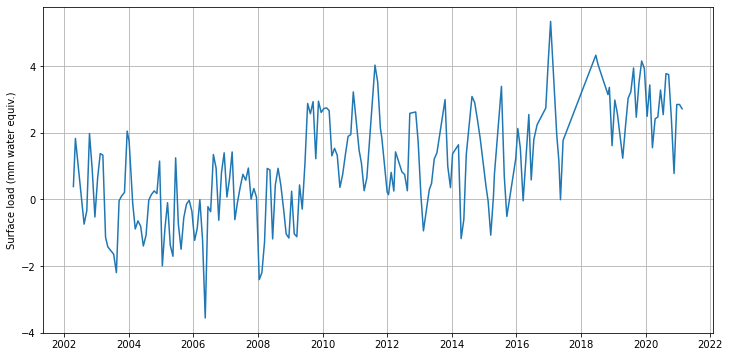

In [4]:
seattle = ds.isel(lat=47, lon=-122)
plt.subplots(figsize=(12,6))
plt.plot(seattle.time,seattle.lwe_thickness)
plt.grid()
plt.ylabel('Surface load (mm water equiv.)')

In [5]:
number_of_time_steps = len(ds.time)
data_matrix = np.zeros((360*720,number_of_time_steps))

for i in range(number_of_time_steps):
    this_data = ds.isel(time=i).lwe_thickness # what does this do?
#     print(this_data.values.flatten().shape)
    data_matrix[:,i] = this_data.values.flatten()
    
#     fig,ax = plt.subplots(figsize=(12,12))
#     globe_2010.plot(vmin=-10,vmax=10)


The Singular Value Decomposition writes a matrix D as

D = U * S * V

In [6]:
from scipy.sparse.linalg import svds
u,s,v = svds(data_matrix,k=7)
print(s)

[  6618.979566     7246.31299665  12092.53326692  12810.95678694
  16579.71881291  22979.22477239 161493.29184373]


In [7]:
u.shape

(259200, 7)

In [8]:
s.shape

(7,)

In [9]:
v.shape

(7, 194)

In [10]:
which_mode = 6

first_left_singular_vector = np.reshape(u[:,which_mode],this_data.values.shape)
first_right_singular_vector = v[which_mode,:]
print(first_left_singular_vector.shape)
print(first_right_singular_vector.shape)

(360, 720)
(194,)


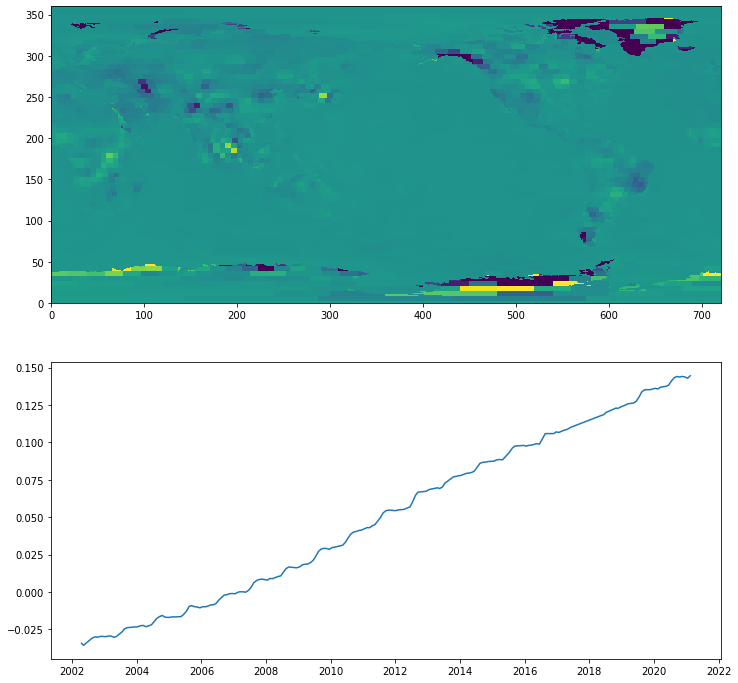

In [11]:
plt.subplots(2,1,figsize=(12,12))
plt.subplot(2,1,1)
plt.pcolor(first_left_singular_vector,vmin=-0.005,vmax=0.005)
plt.subplot(2,1,2)
plt.plot(ds.time,first_right_singular_vector)

<BarContainer object of 7 artists>

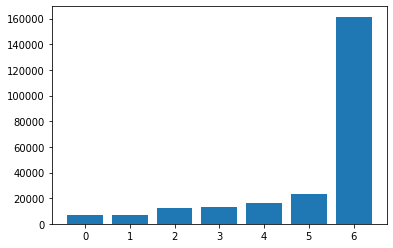

In [12]:
plt.bar(range(len(s)),s)

In [13]:
s

array([  6618.979566  ,   7246.31299665,  12092.53326692,  12810.95678694,
        16579.71881291,  22979.22477239, 161493.29184373])

In [14]:
s[6]/sum(s)

0.6733909027650883

# For next time:

## Calculate the surface mass load at a given point in space and time

Remember D = U * S * V, so to approximate D using the first mode, you would use

D = U[:,6]*S[6]*V[6,:]

Then every column will need to be np.reshaped()'d to the right size to make a map

In [15]:
type(data_matrix)
print(u[:,6].shape)
print(s[6].shape)
print(v[6,:].shape)

(259200,)
()
(194,)


In [16]:
D = u[:,6].reshape(259200,1)*s[6]@v[6,:].reshape(1,194)
print(D.shape)

(259200, 194)


In [17]:
# Finds index of closest time to some input time
time_index = np.argmin(np.abs(ds.time.values - np.datetime64('2010-01-01')))
this_latitude = 47
this_longitude = -122

# Finds index of closest latitude to some input latitude
lat_index = np.argmin(np.abs(ds.lat.values - this_latitude))

# Finds index of closest longitude to some input longitude
lon_index = np.argmin(np.abs(ds.lon.values - this_longitude))

nlong = len(ds.lon)
pos_index = (lat_index -1) * nlong + lon_index

D[pos_index, time_index]

-0.8381701708909718

<ipython-input-18-a88fc7387db7>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = plt.pcolor(ds.lon.values,ds.lat.values, data_reconstruction,vmin=-10,vmax=10, cmap = 'seismic')


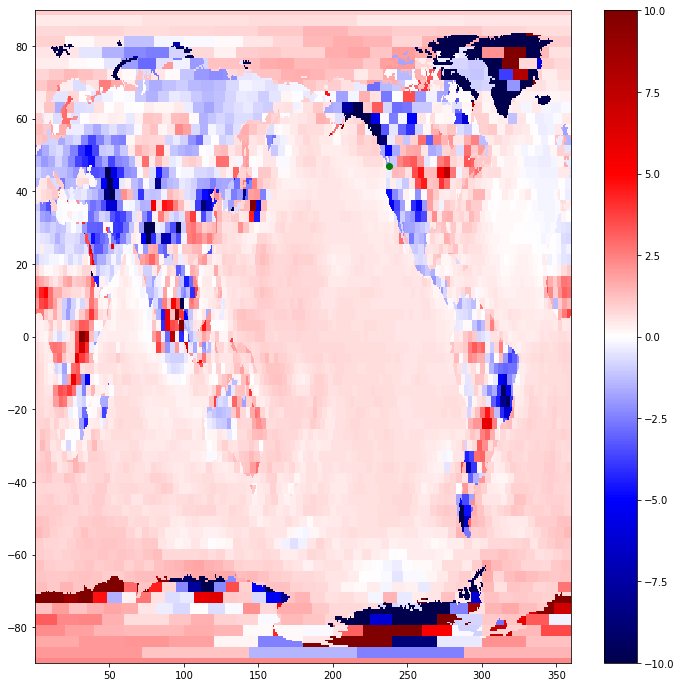

In [18]:
data_reconstruction = first_left_singular_vector * s[6] * v[6, time_index]

plt.subplots(figsize=(12,12))
c = plt.pcolor(ds.lon.values,ds.lat.values, data_reconstruction,vmin=-10,vmax=10, cmap = 'seismic')
plt.plot(this_longitude + 360, this_latitude,'og')
plt.colorbar(c)

In [19]:
## open eq catalog, pull out lat long time and find D at that point

catalog = pd.read_csv(dataset_path + 'ind_and_bg_probs.csv')
catalog["time"] = catalog["time"].astype("datetime64")

# Finds index of closest time to some input time
time_index = np.argmin(np.abs(ds.time.values - np.datetime64('2021-02-16')))
this_latitude = - 17.8133
this_longitude = 167.6409

# Finds index of closest latitude to some input latitude
lat_index = np.argmin(np.abs(ds.lat.values - this_latitude))

# Finds index of closest longitude to some input longitude
lon_index = np.argmin(np.abs(ds.lon.values - this_longitude))

nlong = len(ds.lon)
pos_index = (lat_index -1) * nlong + lon_index

D[pos_index, time_index]

4.259536551921816

In [20]:
# catalog.rename(columns={'time': 'eq_time', 'latitude': 'eq_lat', 'longitude': 'eq_lon'}, inplace=True)

In [21]:
type(catalog)

pandas.core.frame.DataFrame

In [22]:
def calculate_D(eq_time, eq_lat, eq_lon):
    time_index = np.argmin(np.abs(ds.time.values - np.datetime64(eq_time)))
    lat_index = np.argmin(np.abs(ds.lat.values - eq_lat))
    lon_index = np.argmin(np.abs(ds.lon.values - eq_lon))
    nlong = len(ds.lon)
    pos_index = (lat_index -1) * nlong + lon_index
    print(D[pos_index, time_index])
    

In [23]:
catalog_array = catalog.to_numpy()

eq_lat = catalog_array[:,1]
eq_lon = catalog_array[:,2]
eq_time = catalog_array[:,3]

calculate_D(eq_time[1], eq_lat[1], eq_lon[1])


total = len(catalog)

D_values = np.zeros(total)

for i in range(total):
    D_val = calculate_D(eq_time[i], eq_lat[i], eq_lon[i])
    D_values[i] = D_val
    

4.259536551921816
4.259536551921816
4.259536551921816
4.259536551921816
6.973860893245332
2.5773367423183906
4.319396294927257
3.1934260969521957
6.973860893245332
6.973860893245332
-5.497555385894189
4.319396294927257
4.319396294927257
3.8778213540845563
4.319396294927257
4.319396294927257
4.319396294927257
3.8778213540845563
4.319396294927257
4.319396294927257
4.319396294927257
4.319396294927257
4.319396294927257
3.8778213540845563
4.319396294927257
3.8778213540845563
3.8778213540845563
4.319396294927257
3.8778213540845563
4.319396294927257
3.8778213540845563
4.319396294927257
4.319396294927257
-2.052636456699518
3.8778213540845563
4.319396294927257
3.781334313770888
5.289188931817021
3.4380518994415348
1.329852295445929
3.282154720990982
-1.55908617283748
3.026336668648546
4.319396294927257
1.1928610148079604
4.890873934082039
4.319396294927257
4.319396294927257
4.319396294927257
4.1824792087094815
1.9046571319926155
4.1309648706199145
5.962387687569651
10.011296188956843
10.0112961

4.095926877026402
5.729855959131762
4.256813454539382
2.422653252480445
3.4236813123777488
3.3190096427195774
-1.259101967090447
9.081623910469162
4.095926877026402
5.1911743476991425
4.095926877026402
4.095926877026402
4.095926877026402
1.0147855892927775
-11.98359106738421
2.824031403588682
9.081623910469162
3.28101862052208
4.488029976675347
8.593746899061324
3.0572572646328906
3.0572572646328906
3.5474432511519063
3.3905009642635893
-0.34693085372498933
0.705792483410086
4.4997671815492275
5.507073629079389
0.24214540583275024
4.716724089362135
3.289599220015449
4.125255066827613
-0.20554515282217634
0.9963256936755797
3.3567916867362326
4.106638644361723
4.106638644361723
4.106638644361723
5.051700872350052
11.79350882539952
-9.03245875671883
3.0529293126817274
2.880248698405001
3.6331950783914455
-0.20554515282217634
-12.953706720446512
3.3276895972558536
2.5746500262045946
4.106638644361723
2.5746500262045946
-5.888299047192065
-5.888299047192065
-5.888299047192065
2.62936089313

2.8731729976571803
6.946929705938581
3.1216525858255313
4.7491518060652735
2.3433486926219103
7.341314989005717
3.329308316247533
1.7678612608377868
2.2956852989874843
7.341314989005717
2.682988800126716
3.326035322252292
1.767861260837787
4.196391132798728
1.7678612608377868
1.7678612608377868
4.783549743115792
2.6522779863498296
9.5086549294849
1.767861260837787
1.767861260837787
1.767861260837787
3.3110256131088676
2.7793024685768644
2.2959341075658783
1.7503054056583385
2.7064847090046964
1.7503054056583385
1.7503054056583385
1.7503054056583385
2.3348290992481604
2.2731341924442128
2.2731341924442128
2.2731341924442128
2.2731341924442128
9.414228645821513
0.4463448754157849
3.374265115743332
1.6995493314420116
3.374265115743332
2.2731341924442128
2.2731341924442128
2.2731341924442128
3.374265115743332
-1.8613832637500831
0.7612485477517165
3.416889341171906
1.9502261934923026
2.4124322887240854
2.260192982887355
1.12761049299052
2.1472334229470955
-5.205822245131194
7.2684116081642

1.9181170208791505
2.0668137416649777
2.0668137416649777
2.1302090362349473
1.8376878423642722
0.8072114483046404
2.6004516534983266
2.6004516534983266
2.3689042927691064
44.372758710723964
44.372758710723964
2.055911149645659
44.372758710723964
44.372758710723964
2.578173607112938
0.28586817101597856
1.8279939060408086
2.1189720294501817
3.681301205868994
49.210846868775704
2.1189720294501817
-3.8485167643565865
-3.8485167643565865
2.566538843132797
-1.0366350151228516
3.681301205868994
1.5262819253111228
1.5262819253111228
1.5262819253111228
8.760124229759493
2.062236258239534
2.8535776104361674
0.20068409115774644
5.384906978736266
1.8279939060408086
1.8547426889324063
2.6004516534983266
1.5372557330329915
2.391888359009558
-0.7889628411405145
0.9130248491348337
1.7823647433535768
2.055911149645659
-3.6800287372129254
1.8279939060408086
2.4899405515428144
2.4899405515428144
2.079716612264412
0.9736213978056792
5.690614413962454
3.4417730910973177
2.0105153396314317
0.025494724259234

1.4589790723541156
1.4589790723541156
-4.743681217735301
-0.2315806303375601
0.2047624339944022
1.1327959192072685
1.1327959192072685
0.28162693708031367
1.2186086177201656
-3.4886423907946305
2.8924056768443243
1.5677673389725035
2.1726795654080537
1.1157783229139824
1.071111859137307
1.5038617922803472
1.7157333912675732
2.2469322576007174
-0.9887345123944239
1.1327959192072685
1.0926438461715267
-0.8539167551254294
1.2416103042925943
1.1780601763169236
1.1318929450428905
2.157056085161108
1.6478264888925178
0.8029593590881994
-2.3881910436684026
2.1726795654080537
3.155282797286797
1.5106791747870452
0.900754012766218
0.900754012766218
1.2623541101993183
1.2292658788612585
-2.791743035181727
1.2292658788612585
1.2623541101993183
1.2623541101993183
1.2623541101993183
2.1726795654080537
-0.5633979927052704
1.1067126217718433
-4.7436812177353
1.6720519742469224
1.1352234310657747
1.649208384870333
1.1327959192072685
2.8924056768443243
1.649208384870333
3.334411873272847
-3.488642390794

0.5868763645771601
1.5567425641411732
0.5796727225756233
1.5567425641411732
0.5796727225756233
-0.2583954311820187
0.5265941450640705
1.0490290993102613
0.6195584791532346
0.7113878186965925
-1.781049687742786
0.5991940084292948
0.6195584791532346
1.1081751472409682
0.6704716950355434
0.3643916922333134
0.8773355892231909
0.6195584791532346
0.6195584791532346
0.6195584791532346
0.6550185168018954
-0.24428490424050023
0.5890960182404344
0.5753950000422208
0.622679010899096
0.3124837525974284
0.622679010899096
1.4457745602706773
0.5107975553467649
0.522330950949956
0.5647415147790141
0.5329999421223138
0.6482604149492713
0.6482604149492713
-0.047243035619366935
0.5658332919225404
0.46970438154384864
0.622679010899096
1.8726033987139319
-0.24428490424050023
-1.4477030761507865
0.5107975553467649
0.613355514017083
0.5283790381591722
0.874427191046985
0.5658332919225404
0.6520625537804035
0.5107975553467649
0.02234313660304931
0.7144845051917824
0.4195311893145995
0.4590327751927401
0.58510

-0.02161942923791581
0.0033504581551607876
-0.05688546005277848
-0.03213690748245639
-0.03241795868324998
-0.044981600362234635
-0.037872391445066135
-0.039659548260319845
-0.13536618414567575
-0.13536618414567575
-0.11389490844577019
-0.10764287062149981
-0.025205291652350435
-0.01740463133873105
-0.02161942923791581
-0.02161942923791581
-0.03176905258085854
-0.027737739460368296
-0.031067571937815567
-0.027737739460368296
-0.04498556657572271
-0.049557344642247717
-0.04498556657572271
-0.04498556657572271
-0.02161942923791581
-0.02161942923791581
-0.02161942923791581
-0.02161942923791581
-0.044981600362234635
-0.02161942923791581
-0.02161942923791581
-0.02161942923791581
-0.02161942923791581
-0.04498556657572271
-0.02161942923791581
-0.02161942923791581
-0.02161942923791581
-0.02161942923791581
-0.044981600362234635
-0.02161942923791581
-0.02161942923791581
-0.04498160036223461
-0.044981600362234635
-0.044981600362234635
-0.04498556657572271
-0.04498556657572271
-0.04498556657572271
